# Import Libraries and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yfinance as yahooFinance
from pandasql import sqldf

In [16]:
AAPL = yahooFinance.Ticker("AAPL")
df =  pd.DataFrame(AAPL.history(period="3y")).reset_index()

In [21]:
df.columns = list(map(str.lower,df.columns.tolist()))

In [22]:
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

print(df.shape)

df.head()

(755, 7)


,open,high,low,close,volume,dividends,stock splits
date,,,,,,,
2020-09-09 00:00:00-04:00,115.178113,117.024732,113.213622,115.237045,176940500,0.0,0.0
2020-09-10 00:00:00-04:00,118.223066,118.360579,110.502616,111.475037,182274400,0.0,0.0
2020-09-11 00:00:00-04:00,112.535853,113.184138,108.046991,110.011482,180860300,0.0,0.0
2020-09-14 00:00:00-04:00,112.683200,113.871716,110.797290,113.311836,140150100,0.0,0.0
2020-09-15 00:00:00-04:00,116.229113,116.720236,111.592913,113.488647,184642000,0.0,0.0


# Data Preparation

In [23]:
df_week = df.resample('w').mean()
df_week = df_week[['close']]
df_week.head()

,close
date,
2020-09-13 00:00:00-04:00,112.241188
2020-09-20 00:00:00-04:00,110.052745
2020-09-27 00:00:00-04:00,107.950743
2020-10-04 00:00:00-04:00,112.893404
2020-10-11 00:00:00-04:00,113.288266


In [24]:
df_week['weekly_ret'] = np.log(df_week['close']).diff()
df_week.head()

,close,weekly_ret
date,,
2020-09-13 00:00:00-04:00,112.241188,NaN
2020-09-20 00:00:00-04:00,110.052745,-0.019690
2020-09-27 00:00:00-04:00,107.950743,-0.019285
2020-10-04 00:00:00-04:00,112.893404,0.044769
2020-10-11 00:00:00-04:00,113.288266,0.003492


In [25]:
# drop null rows
df_week.dropna(inplace=True)

<Axes: xlabel='date'>

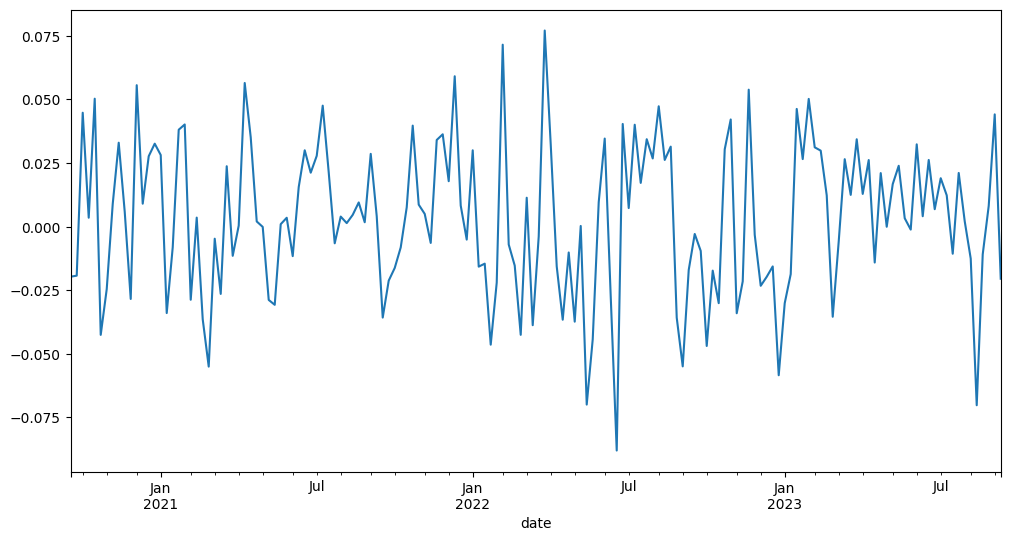

In [26]:
df_week.weekly_ret.plot(kind='line', figsize=(12, 6))

In [27]:
udiff = df_week.drop(['close'], axis=1)
udiff.head()

,weekly_ret
date,
2020-09-20 00:00:00-04:00,-0.019690
2020-09-27 00:00:00-04:00,-0.019285
2020-10-04 00:00:00-04:00,0.044769
2020-10-11 00:00:00-04:00,0.003492
2020-10-18 00:00:00-04:00,0.050285


# Test for Stationary 

In [30]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [31]:
rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

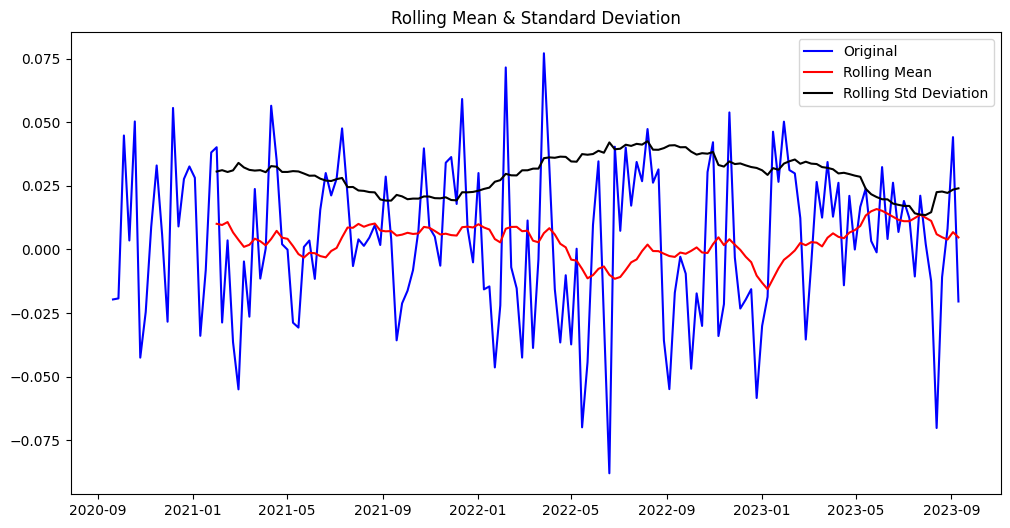

In [32]:
plt.figure(figsize=(12, 6))
orig = plt.plot(udiff, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

In [33]:
# Perform Dickey-Fuller test
dftest = sm.tsa.adfuller(udiff.weekly_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput

Test Statistic                -9.758267e+00
p-value                        7.684913e-17
#Lags Used                     0.000000e+00
Number of Observations Used    1.550000e+02
Critical Value (1%)           -3.473259e+00
Critical Value (5%)           -2.880374e+00
Critical Value (10%)          -2.576812e+00
dtype: float64

p value under 0.05 can reject null hypothesis. This data is stationer

# ACF and PCF chart

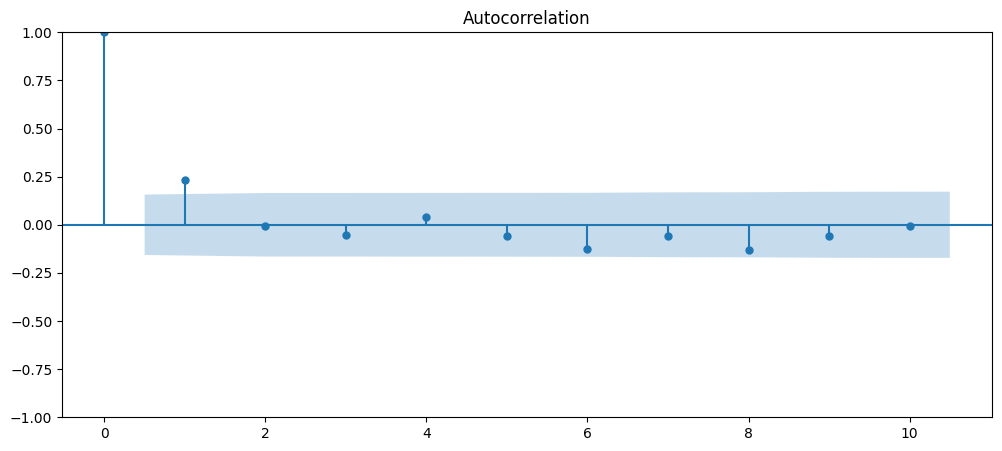

In [34]:
from statsmodels.graphics.tsaplots import plot_acf

# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(udiff.values, lags=10, ax=ax)
plt.show()

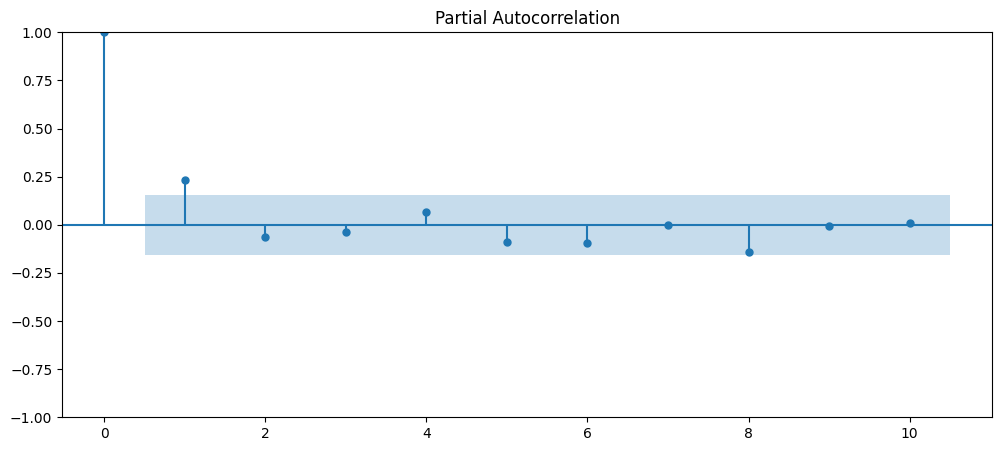

In [35]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(udiff.values, lags=10, ax=ax)
plt.show()

The table below summarizes the patterns of the ACF and PACF.

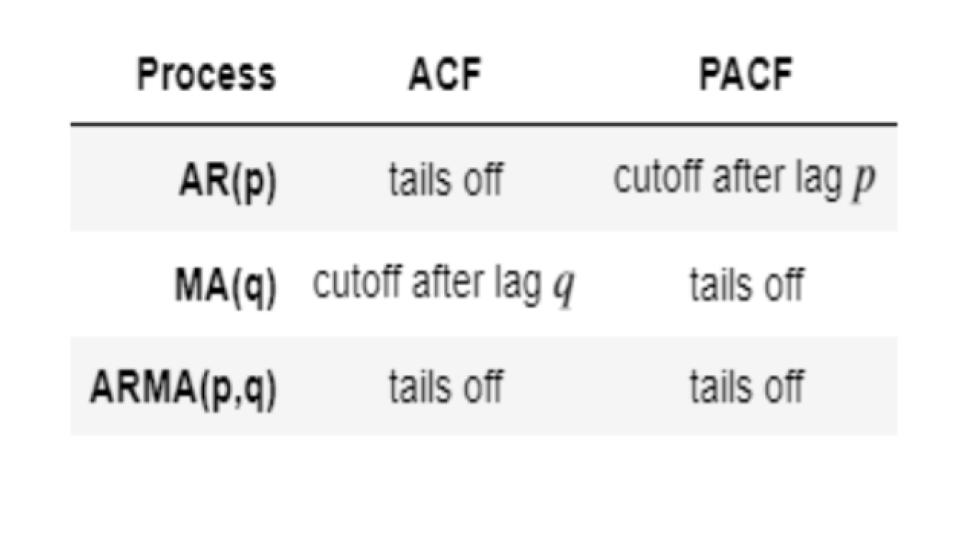
The above chart shows that reading PACF gives us a lag "p" = 3 and reading ACF gives us a lag "q" of 1. Let's Use Statsmodel's ARMA with those parameters to build a model. The way to evaluate the model is to look at AIC - see if it reduces or increases. The lower the AIC (i.e. the more negative it is), the better the model.

# Develope ARIMA Model

In [36]:
from statsmodels.tsa.arima.model import ARIMA

# Notice that you have to use udiff - the differenced data rather than the original data.
ar1 = ARIMA(udiff.values, order = (3, 0,1)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  156
Model:                 ARIMA(3, 0, 1)   Log Likelihood                 330.205
Date:                Mon, 11 Sep 2023   AIC                           -648.410
Time:                        13:53:24   BIC                           -630.111
Sample:                             0   HQIC                          -640.978
                                - 156                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.003      1.052      0.293      -0.003       0.009
ar.L1         -0.2428      0.890     -0.273      0.785      -1.987       1.502
ar.L2          0.0699      0.221      0.316      0.752      -0.364       0.504
ar.L3         -0.0946      0.096     -0.983      0.326      -0.283       0.094
ma.L1          0.4895      0.905      0.541      0.589      -1.284       2.263
sigma2         0.0008      0.000      8.467      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.09
Prob(Q):                              0.95   Prob(JB):                         0.95
Heteroskedasticity (H):               0.99   Skew:                            -0.06
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

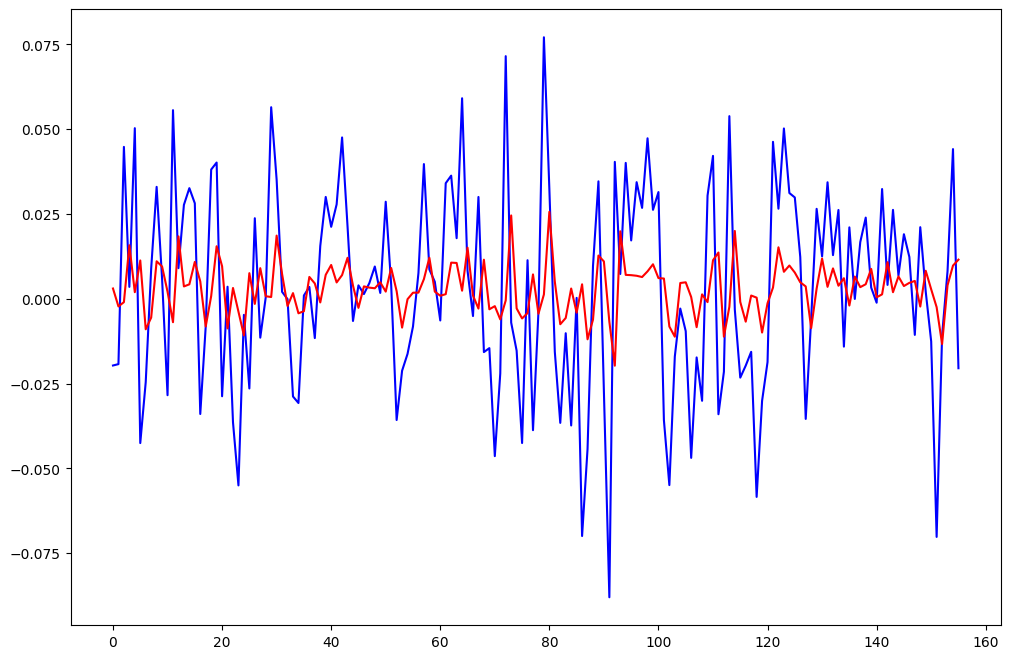

In [37]:
plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')
preds = ar1.fittedvalues
plt.plot(preds, color='red')
plt.show()

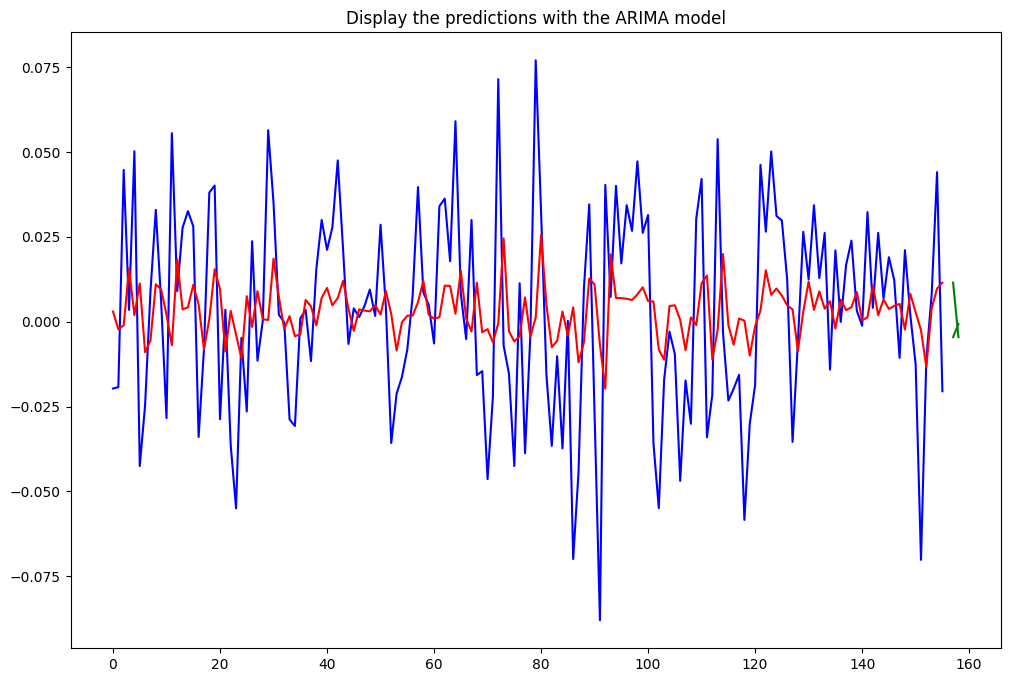

In [38]:
steps = 2

forecast = ar1.forecast(steps=steps)

plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')

preds = ar1.fittedvalues
plt.plot(preds, color='red')

plt.plot(pd.DataFrame(np.array([preds[-1],forecast[0]]).T,index=range(len(udiff.values)+1, len(udiff.values)+3)), color='green')
plt.plot(pd.DataFrame(forecast,index=range(len(udiff.values)+1, len(udiff.values)+1+steps)), color='green')
plt.title('Display the predictions with the ARIMA model')
plt.show()